[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hendersonneurolab/CogAI_Fall2025/blob/master/Lab04_Multimodal_CLIP.ipynb)

## Lab Exercise 4: Language and multimodal models

In this tutorial, we'll work with a more advanced multimodal DNN, the CLIP model. This is a powerful model that takes in both language and image inputs, and maps them into a shared embedding space. We will:

1. Load the text encoder of a pre-trained CLIP model, and visualize how it processes a sentence, including tokenization and self-attention.
2. Use the vision encoder and text encoder together to explore zero-shot image classification.

**Learning objectives:**
- Understand the input and outputs of a language model.
- Develop intuition for self-attention in a language model.
- Understand how models integrate vision and language inputs, and how this can be used to build a decoder.


More info about CLIP implementation can be found here: https://huggingface.co/docs/transformers/en/model_doc/clip.
We're using an implementation of the model from the HuggingFace model repository.

More info about CLIP (Contrastive Language-Image Pretraining) here:
https://arxiv.org/abs/2103.00020



In [1]:
# Install required packages
# (note that we need the ! before this line, this tells colab to run this as a shell command)
# !pip install torch torchvision transformers tokenizers matplotlib seaborn
!pip install transformers tokenizers
# we're installing transformers and tokenizers from the HuggingFace library here
# https://huggingface.co/docs/transformers/en/index

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPTokenizer, CLIPTextModel, CLIPProcessor, CLIPModel, CLIPImageProcessor
from collections import Counter
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import os

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


**Step 1: Prepare a sentence for the language encoder.**

In order for the DNN to process a sentence input, we first need to convert it into a series of numbers. To do this, we'll load a function called a "tokenizer". This is a function that was learned during construction of the CLIP model, and is specific to the dataset it was trained on. It maps from each word (or sometimes, just a part of longer words), to a number in a fixed set of numbers. The set of possible numbers is the "vocabulary size" of the tokenizer.

Note: we might get a warning in this cell, like "The secret `HF_TOKEN` does not exist". You can safely ignore this!

In [2]:
# Load CLIP's tokenizer: this is the part that converts a sentence into tokens
# Like "pre-processing" the sentence for our language model.

# When we specify "clip-vit-base-patch32", this is the name of a pre-trained model.
# We'll use the same tokenizer that was used during training of this model.
# In this case it's learned using Byte Pair Encoding.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# how many possible words/word parts can we represent?
print('Vocabulary size: %d'%tokenizer.vocab_size)

# what is the max length of an input to this model?
print('Model max length: %d'%tokenizer.model_max_length)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Vocabulary size: 49408
Model max length: 77


In [3]:
# Let's enter an example sentence - you can try your own too.
sentence = "The brain is superlatively cool."
#  and we love to study it."
# sentence = 'Neural networks are trained on lots of'
print(f"Original sentence: '{sentence}'")

# Tokenize the sentence
# The </w> signals the end of a word.
# Notice that long words like "superlatively" get broken into a few parts.
# The </w> only comes at the end of a whole word.
tokens = tokenizer.tokenize(sentence)
print('Number of tokens in my sentence: %d'%len(tokens))
# print(f"Tokens: {tokens}")

# Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
# print(f"Token IDs: {token_ids}")

pd.DataFrame(np.array([tokens, token_ids]).T, index=np.arange(len(tokens)), columns = ['Token','Token ID'])

Original sentence: 'The brain is superlatively cool.'
Number of tokens in my sentence: 8


,Token,Token ID
0,the</w>,518
1,brain</w>,4812
2,is</w>,533
3,super,1642
4,l,75
5,atively</w>,11929
6,cool</w>,2077
7,.</w>,269


The tokenizer also has elements for special sentence parts, like start and end of the sequence. Let's explore these now:

In [4]:

print("Special tokens in CLIP:")
print(f"Start of sequence: '{tokenizer.bos_token}' (ID: {tokenizer.bos_token_id})")
print(f"End of sequence: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"Padding token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")

# See how they're added to our sentence
full_encoding = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
print(f"\nFull token sequence: {full_encoding['input_ids'][0].tolist()}")

# Decode to see the full sequence
decoded_tokens = tokenizer.convert_ids_to_tokens(full_encoding['input_ids'][0])
print(f"Decoded tokens: {decoded_tokens}")

pd.DataFrame(np.array([full_encoding['input_ids'][0].tolist(), decoded_tokens]).T, index=np.arange(len(decoded_tokens)), columns = ['Token','Token ID'])

Special tokens in CLIP:
Start of sequence: '<|startoftext|>' (ID: 49406)
End of sequence: '<|endoftext|>' (ID: 49407)
Padding token: '<|endoftext|>' (ID: 49407)

Full token sequence: [49406, 518, 4812, 533, 1642, 75, 11929, 2077, 269, 49407]
Decoded tokens: ['<|startoftext|>', 'the</w>', 'brain</w>', 'is</w>', 'super', 'l', 'atively</w>', 'cool</w>', '.</w>', '<|endoftext|>']


,Token,Token ID
0,49406,<|startoftext|>
1,518,the</w>
2,4812,brain</w>
3,533,is</w>
4,1642,super
5,75,l
6,11929,atively</w>
7,2077,cool</w>
8,269,.</w>
9,49407,<|endoftext|>



---
***Question 1:***


Try entering your own sentence above ("sentence = "). Print out the following: the full list of tokens in your sentence, the full list of token IDs in your sentence, and the total number of tokens in your sentence.


In [5]:
# answer here
sentence = "The quick brown fox jumps over the lazy dog"
print(f"Original sentence: '{sentence}'")
tokens = tokenizer.tokenize(sentence)
print('Number of tokens in my sentence: %d'%len(tokens))
tokenIds = tokenizer.convert_tokens_to_ids(tokens)
pd.DataFrame(np.array([tokens, tokenIds]).T, index=np.arange(len(tokens)), columns = ['Token','Token ID'])


Original sentence: 'The quick brown fox jumps over the lazy dog'
Number of tokens in my sentence: 9


,Token,Token ID
0,the</w>,518
1,quick</w>,3712
2,brown</w>,2866
3,fox</w>,3240
4,jumps</w>,18911
5,over</w>,962
6,the</w>,518
7,lazy</w>,10753
8,dog</w>,1929




---



In [6]:
# back to original sentence
sentence = "The brain is superlatively cool."

**Step 2: Load the CLIP text encoder.**

Recall that CLIP has two branches: a vision encoder and text encoder, which converge on a shared latent space. For now, let's load just the text encoder portion. It has a transformer architecture. We'll load a set of weights from a pre-trained model.

In [7]:
# Load CLIP model
model_name = "openai/clip-vit-base-patch32"
text_model = CLIPTextModel.from_pretrained(model_name, attn_implementation="eager").to(device)

# Let's examine the model architecture
print("CLIP Text Encoder Architecture:")
print(text_model)

# Key parameters
print(f"\nKey parameters:")
print(f"Vocabulary size: {text_model.config.vocab_size}")
print(f"Hidden size (embedding dimension): {text_model.config.hidden_size}")
print(f"Number of attention heads: {text_model.config.num_attention_heads}")
print(f"Number of transformer layers: {text_model.config.num_hidden_layers}")
print(f"Maximum sequence length: {text_model.config.max_position_embeddings}")

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP Text Encoder Architecture:
CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_

Compute the first layer embeddings: here we're taking the token IDs, and linearly mapping these into a lower dimensional vector embedding. In this case it's 512-dimensional.

The other element that is needed here is a position embedding. This is an additional vector that specifies the position of each word in the sentence. Without this, the model doesn't have information about relative positions of words. The position embedding is learned during training, and it gets added onto the embedding of each token.

In [8]:
model = text_model

# Tokenize
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)

# Get the embedding layer (first layer of the model)
with torch.no_grad(): # no_grad: disables computation of model gradients. Because we're not training, just evaluating.
    # Access the embeddings layer
    token_embeddings = model.text_model.embeddings.token_embedding(inputs['input_ids'])
    position_embeddings = model.text_model.embeddings.position_embedding(
        torch.arange(inputs['input_ids'].shape[1], device=device).unsqueeze(0)
    )
    # Position embeddings: store information about token sequence.
    # A different vector is added onto each token, depending on its position.

    # Final embeddings = token embeddings + position embeddings
    final_embeddings = token_embeddings + position_embeddings

print(f"Input shape: {inputs['input_ids'].shape}")
print(f"Token embeddings shape: {token_embeddings.shape}")
print(f"Position embeddings shape: {position_embeddings.shape}")
print(f"Final embeddings shape: {final_embeddings.shape}")


Input shape: torch.Size([1, 10])
Token embeddings shape: torch.Size([1, 10, 512])
Position embeddings shape: torch.Size([1, 10, 512])
Final embeddings shape: torch.Size([1, 10, 512])


Now let's visualize these embeddings. Each row is an embedding vector for one token. The color indicates the value.

We can also plot the similarity between position embeddings for each pair of tokens (bottom plot).

Text(0, 0.5, 'Input token position')

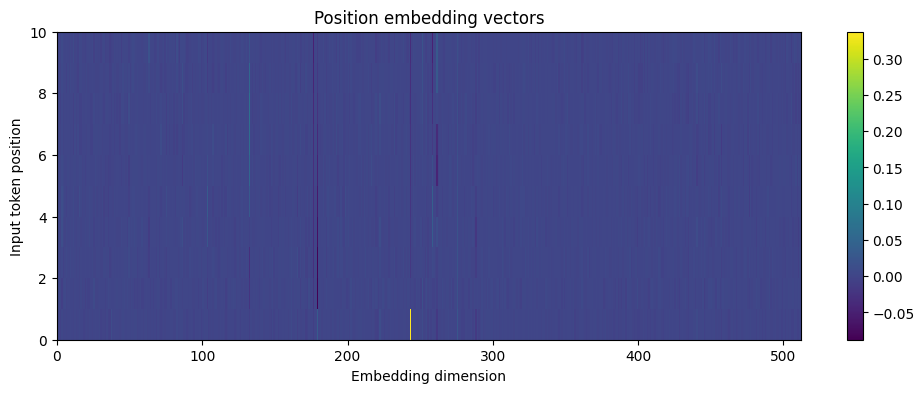

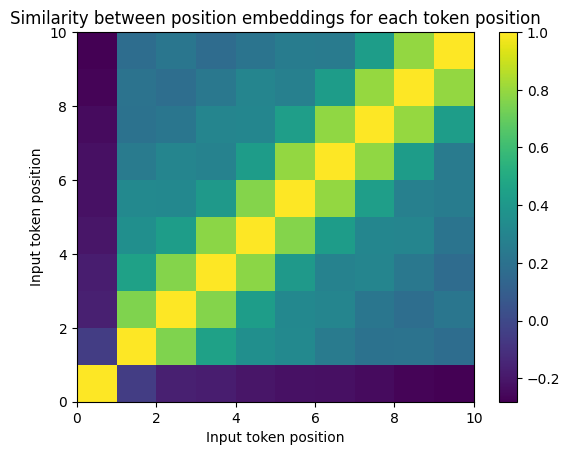

In [9]:
e = position_embeddings[0].numpy()
c = np.corrcoef(e)

plt.figure(figsize=(12,4))
plt.pcolormesh(e)
plt.colorbar()
plt.title('Position embedding vectors')
plt.xlabel('Embedding dimension')
plt.ylabel('Input token position')

plt.figure()
plt.pcolormesh(c)
plt.colorbar()
plt.title('Similarity between position embeddings for each token position')
plt.xlabel('Input token position')
plt.ylabel('Input token position')



---
***Question 2:***

What do you notice about the similarity matrix? Which pairs of tokens are most similar? Why?

The similarity matrix shows us that each token is the most similar to itself (yellow) and it is similar to the tokens near it. As there is more distance from a token, the more dissimilar the other tokens are. For example, input token in position 6 is the most similar to itself, as (6,6) is yellow. However, (1,6) is dark purple, which indiciates dissimilarity. On top of that, a gradual shift from similar to dissimilar can be seen as the token position strays further away from the input token.



---



**Step 3: Implement the self-attention layers**

The transformer is composed of many self-attention layers, which each implement an "attention" operation multiple times.

As an analogy for this, think of searching for a book at the library:

- QUERY (Q): What you're looking for ('information about cats')
- KEY (K): The index/catalog of each book ('this book contains: animals, pets, cats...')
- VALUE (V): The actual content of each book

Attention process:
1. Compare your QUERY with each book's KEY (what topics it covers)
2. Books with relevant KEYs get higher attention scores
3. Take a weighted combination of the VALUES based on attention scores

In transformers:
- Each word has a Query: 'What should I pay attention to?'
- Each word has a Key: 'What information do I contain?'
- Each word has a Value: 'What information should I contribute?'

In this plot, we're going to visualize the weights of one attention head in one layer. These are determined based on similarity between the queries and keys for each token. How much do we "weight" each word earlier in the sentence, when we're processing the current word?

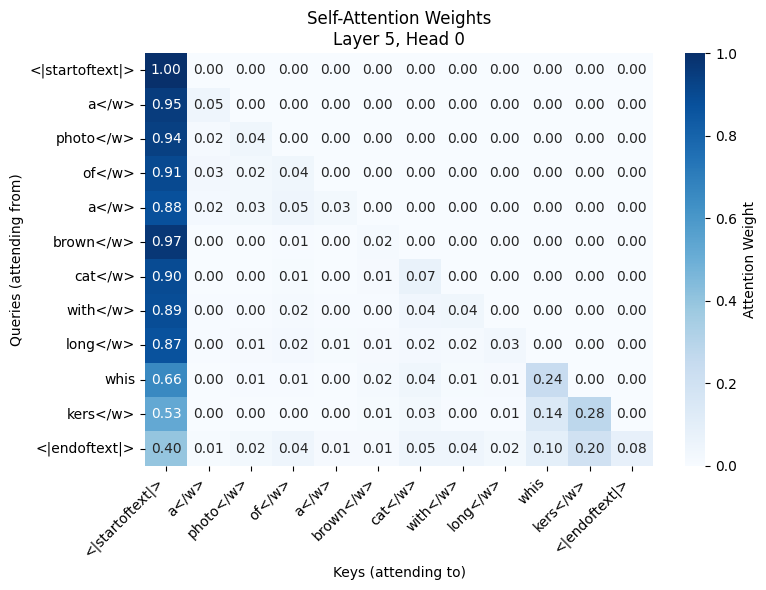

In [32]:
layer_idx = 5  # Which layer to visualize

head_idx = 0   # Which head within the layer to visualize

# We need to modify the model to output attention weights
with torch.no_grad():
    outputs = model(inputs['input_ids'], output_attentions=True)

# Get attention weights from specified layer
attention_weights = outputs.attentions[layer_idx][0]  # Remove batch dimension

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Get specific attention head
head_attention = attention_weights[head_idx].cpu().numpy()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(head_attention,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Attention Weight'})

plt.title(f'Self-Attention Weights\nLayer {layer_idx}, Head {head_idx}')
plt.xlabel('Keys (attending to)')
plt.ylabel('Queries (attending from)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Notice there's a lot of weight assigned to the very first token <startoftext>
# This is sometimes called "attention sink"
# Start token is like a default target for attention, when no other strong relationships exist.



---
***Question 3:***

Which values are 0 in the matrix above? Why are these zeros?



The values that are 0 are the places that the values would attend to in the future, for example, (brain, super) where brain is the query and super is the key and super comes after the brain in the sentence. The queries that are attendeding to itself or words that came previously in the sentence have higher attention weights, while queries attending to future words that are keys have 0 as their attention weight. This is because they haven't attended to them yet.




---



That's just one attention head - there are 8 different ones per layer. Each head can extract different types of information from the sentence. For example, one head could be involved in processing syntax, and another the conceptual meaning of words.

Now let's plot several heads:

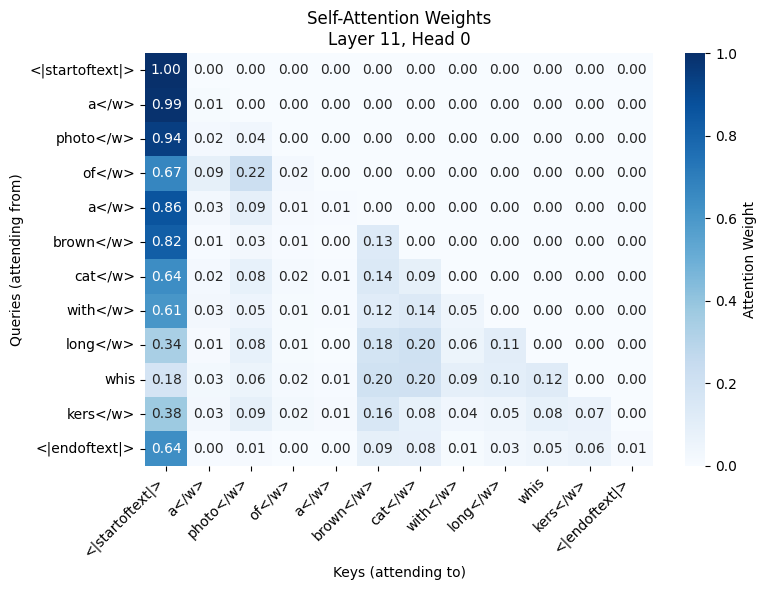

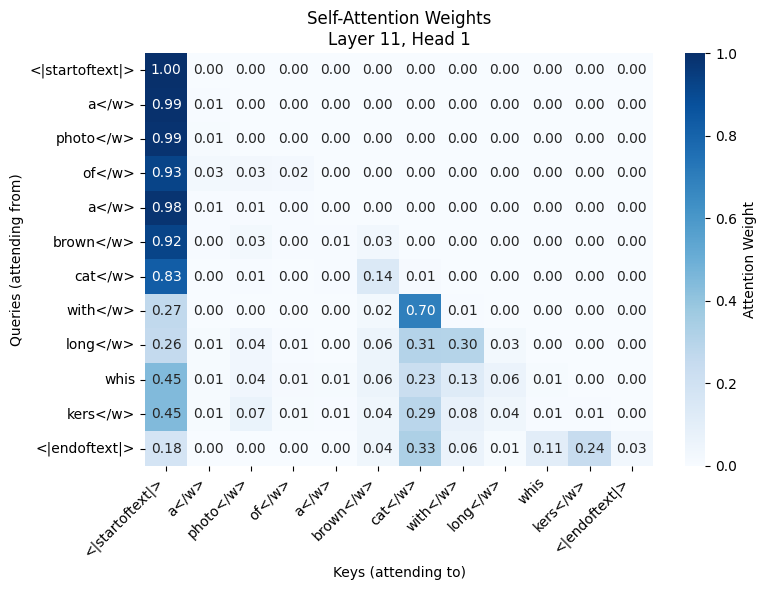

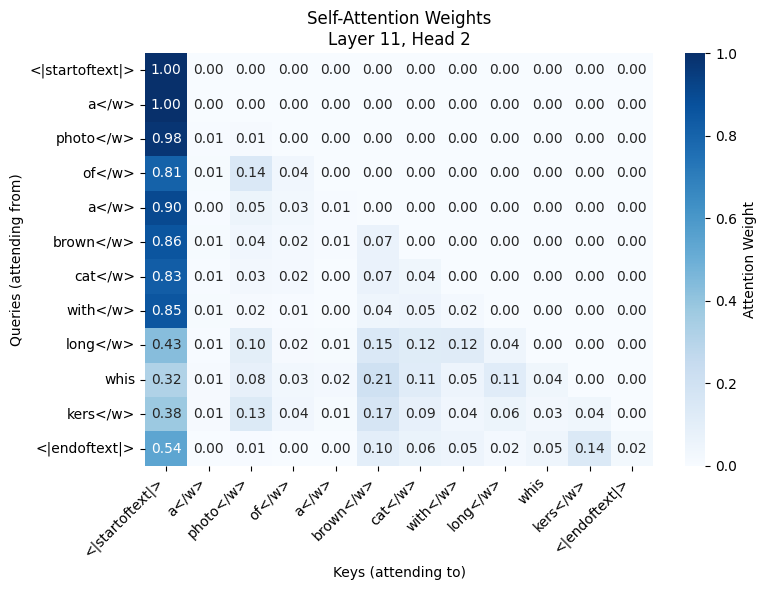

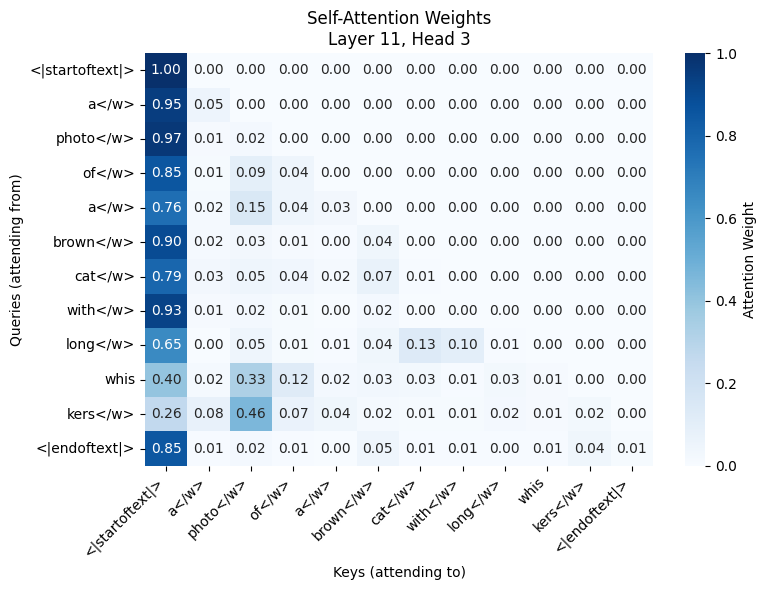

In [34]:
layer_idx = 11  # Which layer to visualize
# layer_idx = 0;

for head_idx in range(4):

  # Get attention weights from specified layer
  attention_weights = outputs.attentions[layer_idx][0]  # Remove batch dimension

  # Get specific attention head
  head_attention = attention_weights[head_idx].cpu().numpy()

  # Create heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(head_attention,
              xticklabels=tokens,
              yticklabels=tokens,
              cmap='Blues',
              annot=True,
              fmt='.2f',
              cbar_kws={'label': 'Attention Weight'})

  plt.title(f'Self-Attention Weights\nLayer {layer_idx}, Head {head_idx}')
  plt.xlabel('Keys (attending to)')
  plt.ylabel('Queries (attending from)')
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()




---

***Question 4:***

What do you think the different attention heads might correspond to in this example? What kinds of information could they each be integrating or processing?


It seems like attention head 0 is processing the formation of the sentence, starting with the <|startoftext|> and piecing the word 'superlatively' together. Attention head 1 is processing the subject of the sentence, which is 'brain', and I think this is the case as the heat map shows higher attention weight on brain. Attention head 2 is processing maybe locality, so the relationship between the words near each other. Lastly, attention head 3 seems to be processing adjectives and the noun that it describes.


---

***Question 5:***
Try changing the value of layer_idx in the code above. How do the self-attention weight matrices change? Are there any differences you can notice between earlier and later model layers?

I changed the layer_idx to 0 and all the heads for this layer show the attention weights being the higest in a diagonal manner. It seems like the input word (query) has the strongest relationship with the previous word/token that came in the sentence. For example, (photo, a), (of, photo), (a,of) where (query, key). It seems like the eariler layers focus more on the basic structure of the sentence by focusing on the words that come before each query. On the other hand, the later layers like layer 11 seem to focus on the semantic relationship each word has with each other, as the attention weights are more spread out.



---



***Question 6:***
Go back to the top of the notebook, and change the input sentence ("sentence = ") to something else. Try both long and short sentences. Do you notice any additional patterns in the attention heads?

[answer here]



---



**Step 4: Extracting the final text embedding.**

After passing the input through each attention layer, we have an embedding corresponding to the whole sentence.

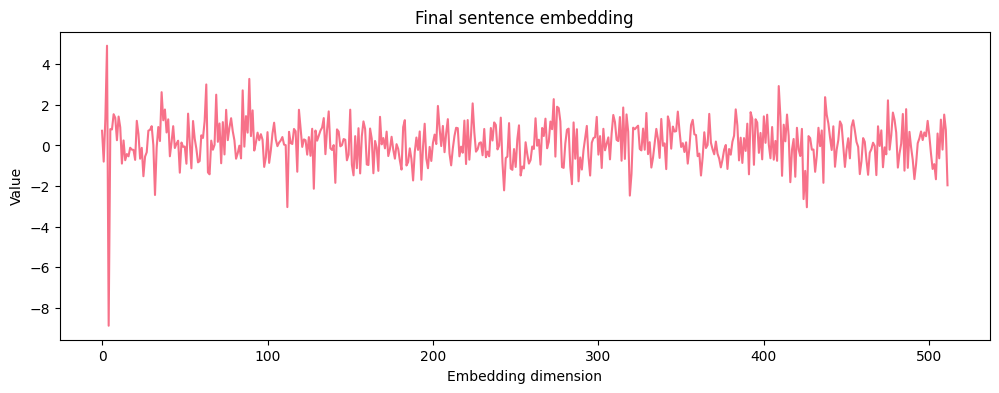

In [12]:
sentence = 'The brain is superlatively cool.'
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)

outputs = text_model(inputs['input_ids'])

e = outputs.last_hidden_state[0].detach().numpy()
# Get out the last hidden state from the model.
# this provides a single 512-D vector for each sentence token.
# To capture the entire sentence, we'll just take the last row of this (last token)
# This corresponds to the end-of-text token.
# It includes information about the entire input.
eot_token_pos = inputs['attention_mask'][0].sum() - 1
sentence_embedding = e[eot_token_pos]

plt.figure(figsize=(12,4))
plt.plot(sentence_embedding)
# plt.plot(sentence_embedding2)
plt.title('Final sentence embedding')
plt.xlabel('Embedding dimension')
plt.ylabel('Value')
plt.show()

**Step 5: Loading the complete model: vision + text**

Now that we've explored the language encoder, let's look at how it works along with the vision encoder.
The vision encoder in this version uses a Vision Transformer architecture (ViT); this is different than the CNNs we've looked at previously. It is similar to the text encoder architecture, in that it uses the same self-attention operation. But it works on visual inputs.

In [13]:
# Load the complete CLIP model (both encoders)
model_name = "openai/clip-vit-base-patch32"

print(f"Loading CLIP model: {model_name}")
clip_model = CLIPModel.from_pretrained(model_name).to(device)
# clip_processor = CLIPProcessor.from_pretrained(model_name)
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")


Loading CLIP model: openai/clip-vit-base-patch32


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [14]:
# let's see what's inside the model.
# it includes both a text model and a vision model component.
clip_model.text_model, clip_model.vision_model


(CLIPTextTransformer(
   (embeddings): CLIPTextEmbeddings(
     (token_embedding): Embedding(49408, 512)
     (position_embedding): Embedding(77, 512)
   )
   (encoder): CLIPEncoder(
     (layers): ModuleList(
       (0-11): 12 x CLIPEncoderLayer(
         (self_attn): CLIPAttention(
           (k_proj): Linear(in_features=512, out_features=512, bias=True)
           (v_proj): Linear(in_features=512, out_features=512, bias=True)
           (q_proj): Linear(in_features=512, out_features=512, bias=True)
           (out_proj): Linear(in_features=512, out_features=512, bias=True)
         )
         (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (mlp): CLIPMLP(
           (activation_fn): QuickGELUActivation()
           (fc1): Linear(in_features=512, out_features=2048, bias=True)
           (fc2): Linear(in_features=2048, out_features=512, bias=True)
         )
         (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
       )
     )
   )

In [15]:
# To handle images, mounting your google drive folder here
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the Colab Notebooks folder
colab_notebooks_path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(colab_notebooks_path)
os.makedirs('CogAI', exist_ok=True)
os.makedirs('CogAI/images', exist_ok=True)

images_folder = os.path.join(colab_notebooks_path, 'CogAI', 'images')
print(images_folder)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/CogAI/images


In [16]:
# Helper function for image downloads
def download_image(url, filepath):
    try:
        headers = {
              'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
          }
        response = requests.get(url, headers=headers, timeout=10)
        # response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raises exception for bad status codes

        # Verify it's an image
        content_type = response.headers.get('content-type', '')
        if not content_type.startswith('image/'):
            print(f"Warning: Content-Type is {content_type}, not an image")
            return False

        with open(filepath, 'wb') as f:
            f.write(response.content)

        # Verify file size
        if os.path.getsize(filepath) < 100:  # Very small files are likely errors
            print("Warning: Downloaded file is suspiciously small")
            return False

        return True

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return False

In [17]:
# Your image URLs
# These are just images from the internet - you can use your own too.
image_urls = {
    "cat": "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Kittyply_edit1.jpg/256px-Kittyply_edit1.jpg",
    # "dog": "https://upload.wikimedia.org/wikipedia/commons/9/90/Labrador_Retriever_portrait.jpg",
    # "car": "https://upload.wikimedia.org/wikipedia/commons/c/c3/2019_Toyota_Corolla_XSE_%28MZEA12L%29_in_Blue_Flame%2C_front_left.jpg",
    # "airplane": "https://upload.wikimedia.org/wikipedia/commons/3/36/United_Airlines_Boeing_777-200_Meulemans.jpg",
}

for name, url in image_urls.items():
  file_path = os.path.join(images_folder, '%s.jpg'%name)
  print(file_path)
  success = download_image(url, file_path)
  print('Success = %s'%success)

/content/drive/MyDrive/Colab Notebooks/CogAI/images/cat.jpg
Success = True


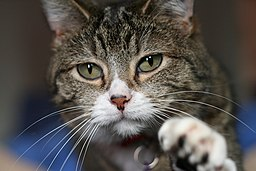

In [18]:
import PIL
name = 'cat'
file_path = os.path.join(images_folder, '%s.jpg'%name)
image = PIL.Image.open(file_path).convert('RGB')
image

In [19]:
# Now extract the CLIP embedding for this image.

image_input = image_processor(image, return_tensors="pt")
image_input = image_input.pixel_values
image_input = image_input.to(device)

image_embedding = clip_model.get_image_features(pixel_values = image_input)[0]
# this is [512] dimensional vector

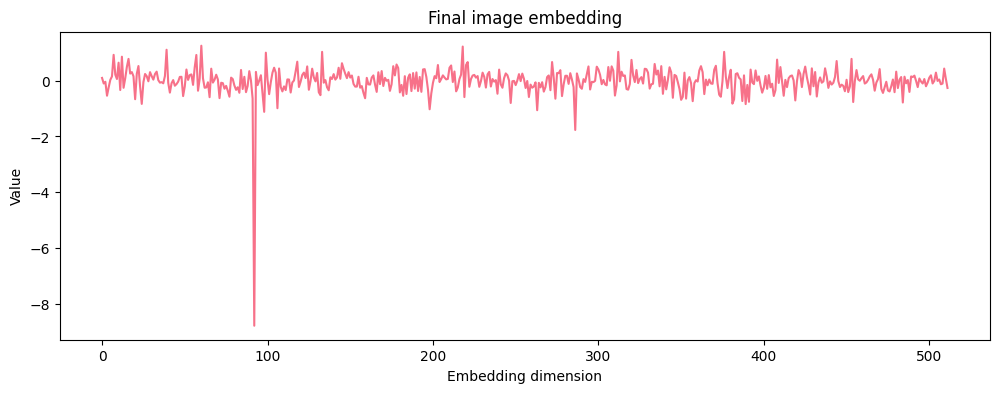

In [20]:
# Let's plot this embedding

plt.figure(figsize=(12,4))
plt.plot(image_embedding.detach().numpy())
# plt.plot(image_embedding2)
plt.title('Final image embedding')
plt.xlabel('Embedding dimension')

plt.ylabel('Value')
plt.show()

Now let's create a caption for our example image...

In [21]:
my_caption = 'A photo of a brown cat with long whiskers'

Now run this caption through the text encoder to get a caption embedding.

In [22]:
# Tokenize
inputs = tokenizer(my_caption, return_tensors="pt", padding=True, truncation=True).to(device)
caption_embedding= clip_model.get_text_features(inputs['input_ids'])[0]

Let's plot these embeddings on top of each other. How similar are they?
Remember, the whole point of this model is to create embeddings for an image and its caption that are very similar.

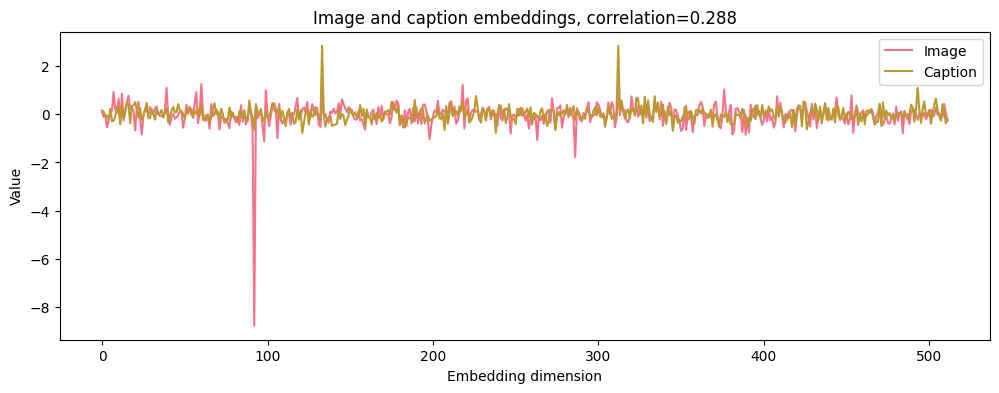

In [23]:

plt.figure(figsize=(12,4))

plt.plot(image_embedding.detach().numpy())
plt.plot(caption_embedding.detach().numpy())
plt.title('Image and caption embeddings, correlation=%.3f'%np.corrcoef(image_embedding.detach().numpy(), caption_embedding.detach().numpy())[0,1])
plt.xlabel('Embedding dimension')
plt.ylabel('Value')
# plt.show()

plt.legend(['Image','Caption'])

**Step 6: Use this to create a zero-shot image classifier**

Zero-shot refers to being able to classify things it wasn't directly trained on. We can create any set of classes we want and use any image we want. The model can use what it already knows about language, images, and their relationship, to perform classification.

The key idea is that we will create a set of possible captions for the image, and extract embeddings for each. Then we'll decide which caption has the most similar embedding to our image.

In [24]:
# these can be anything you want - try making them very similar to make it hard
candidate_labels = ['A photo of a brown cat with long whiskers',
                  'A unicorn on a green lawn',
                  'A piece of pizza',
                  'A large tiger in the jungle',
                  'A white cat with short whiskers',
                  'A medium sized orange kitten']


name = 'cat'
file_path = os.path.join(images_folder, '%s.jpg'%name)
image = PIL.Image.open(file_path).convert('RGB')


In [25]:
# now we run the classifier, by passing images and captions into model.

with torch.no_grad():
  inputs = tokenizer(candidate_labels, return_tensors="pt", padding=True, truncation=True).to(device)
  caption_embeddings= clip_model.get_text_features(**inputs)
  caption_embeddings = torch.nn.functional.normalize(caption_embeddings, dim=-1) # L2 normalization

  image_input = image_processor(image, return_tensors="pt")
  image_input = image_input.pixel_values
  image_input = image_input.to(device)

  image_embedding = clip_model.get_image_features(pixel_values = image_input)
  image_embedding = torch.nn.functional.normalize(image_embedding, dim=-1) # L2 normalization

  # compute embedding similarity: dot product
  similarity = image_embedding @ caption_embeddings.T
  scaled_similarity = similarity * clip_model.logit_scale.exp() # scaling parameter for CLIP

  # Convert to probabilities using softmax
  probabilities = F.softmax(scaled_similarity, dim=1)  # [1, 4]

print(probabilities)

tensor([[9.8854e-01, 2.8388e-06, 6.0077e-05, 2.6868e-04, 1.1076e-02, 5.2929e-05]])




---

***Question 7:***

Write some code to summarize the results of the classifer (print or table form). What probability did it assign to each caption? What was its top prediction?

In [26]:
# answer here


---

***Question 8:***

Make your own zero-shot classifier, for an example image and set of captions of your choosing. Can you find an image that is very difficult to classify? Consider trying: non-natural images like cartoons, or sets of captions that are semantically similar.

In [27]:
# answer here


---